# Предисловие

В данном блокноте мы решим задачу определения черт лица по фото. Обучать будем на датасете CelebA Faces

С полным списком определяемых черт можно ознакомиться на странице датасета или чуть позже в этом блокноте

In [1]:
import torch
import numpy as np
import torchvision.transforms as tt
from torch import nn
from torch.utils.data import  DataLoader, Dataset, ConcatDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from collections import Counter
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score

В исходном датасете метки находятся в виде -1 и 1. Мы это поменяем на 0 и 1 для удобства

In [2]:
import pandas as pd

attributes_path = '/kaggle/input/celeba-dataset/list_attr_celeba.csv'
attributes_df = pd.read_csv(attributes_path)
attributes_df.head()

attributes_df = attributes_df.replace(-1, 0)


Делим датасет на тренировочную и валидационную выборки, прмиеняем трансформации и аугментации

Создаем кастомный класс датасета

In [3]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(attributes_df, test_size=0.2, random_state=42)

image_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

class CelebADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = f'{self.img_dir}/{img_name}'
        image = plt.imread(img_path)
        label = self.df.iloc[idx, 1:].values.astype('float32')

        if self.transform:
            image = self.transform(image)

        return image, label

    @property
    def labels(self):
        return self.df.iloc[:, 1:].values.astype('float32')

transform_train = tt.Compose([
    tt.ToPILImage(),
    tt.Resize((224, 224)),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = tt.Compose([
    tt.ToPILImage(),
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Проблемы и их решение

В датасете по большому количеству признаков присутствует дисбаланс. Например, фотографий лысых людей в датасете всего 2% от общего числа. 

Из-за этого не представляется возможным все 40 признаков представлять в виде one-hot вектора и обучать одну модель. 

Даже если внести изменения в веса классов соответствии с их обратным распределением, проблема не решится, и даже тогда
модель не будет в действительности учиться распознавать некоторые признаки, а просто будет предсказывать более популярный вариант. 

В таком случае accuracy у модели будет довольно высокое, но precision будет оставлять желать лучшего.

Я полагаю, что есть какое-то более оптимальное решение этой проблемы, чем то, которое используется в данном случае, но создание ансамбля мне показалось достаточно простым для понимания и реализации,а так же довольно результативным, хотя, возможно, и не оптимальным по ресурсоемкости

Так как у нас 40 признаков, я буду обучать 40 моделей. Предобученный Resnet50 оказался оптимальным решением в плане ресурсов/качества

Последний Fully-connected слой модели заменяем на подходящий нам, для предсказания именно одного признака

In [5]:
class FeatureModel(nn.Module):
    def __init__(self, pretrained=True):
        super(FeatureModel, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x)

Однако только создание ансамбля все ещё не решит проблему дисбаланса распределения. Поэтому каждый раз для модели будет создаваться датасет, состоящий из 15000 (или менее) картинок с более редким классом, и столько же картинок с другим. Таким образом каждой модели будет подаваться датасет с распределением ровно 1 к 1

In [6]:
def balance_dataset(df, feature_idx, img_dir, transform, max_samples=15000):
    df_1 = df[df.iloc[:, feature_idx] == 1]
    df_0 = df[df.iloc[:, feature_idx] == 0]

    df_1 = df_1.sample(n=min(max_samples, len(df_1)), random_state=42)
    df_0 = df_0.sample(n=min(len(df_1), len(df_0)), random_state=42)

    balanced_df = pd.concat([df_1, df_0])

    return CelebADataset(balanced_df, img_dir, transform)

В качестве метрик для ориентирования будем использовать accuracy и precision

In [7]:
def calculate_metrics(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    accuracy = accuracy_score(labels.flatten(), preds.flatten())
    precision = precision_score(labels.flatten(), preds.flatten(), zero_division=0)

    return accuracy, precision

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
from torch.optim.lr_scheduler import StepLR

## Цикл обучения

Опытным путем я выяснил, что 10 эпох для достижения показателей >0.95  по acc и prec для большинства признаков более чем достаточно

Поэтому мы каждый признак обучаем 10 эпох, или до тех пор, пока не начнется ухудшение метрик. Лучшую версию мы, конечно, сохраняем

In [14]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, feature_idx):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_prec': [], 'val_prec': []}
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_val_prec = 0.0
    best_epoch = 0
    patience = 2
    trigger_times = 0
    
    for epoch in range(1, 11):
        
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        running_prec = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels[:, feature_idx-1].unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            acc, prec = calculate_metrics(outputs, labels)
            running_acc += acc
            running_prec += prec

        train_loss = running_loss / len(train_loader)
        train_acc = running_acc / len(train_loader)
        train_prec = running_prec / len(train_loader)

        val_loss = 0.0
        val_acc = 0.0
        val_prec = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels[:, feature_idx-1].unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                acc, prec = calculate_metrics(outputs, labels)
                val_acc += acc
                val_prec += prec

        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)
        val_prec = val_prec / len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_prec'].append(train_prec)
        history['val_prec'].append(val_prec)

        print(f'Epoch [{epoch}], LR: {scheduler.get_last_lr()[0]:.6f}, Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Train Prec: {train_prec:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.4f}, Val Prec: {val_prec:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_val_prec = val_prec
            best_epoch = epoch
            torch.save(model.state_dict(), f'best_resnet50_feature_{feature_idx}.pth')
            trigger_times = 0
        else:
            trigger_times += 1
            print(f'No improvement. Trigger times: {trigger_times}')
            if trigger_times >= patience:
                print(f'Early stopping at epoch {epoch}. Best epoch: {best_epoch} with Val Loss: {best_val_loss:.4f}, '
                      f'Val Acc: {best_val_acc:.4f}, Val Prec: {best_val_prec:.4f}')
                break

        scheduler.step()

    return history

Ниже представлена лишь меньшая часть обучения, так как за одну сессию натренировать сразу 40 моделей не представлялось возможным

In [15]:
def train_ensemble(df, img_dir, transform_train, transform_val, my_models):
    histories = []

    for feature_idx, model in enumerate(my_models, start=35):
        print(f"Training model for feature {feature_idx}")

        model.to(device)

        train_dataset = balance_dataset(df, feature_idx, img_dir, transform_train)
        val_dataset = balance_dataset(df, feature_idx, img_dir, transform_val)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

        history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, feature_idx)
        histories.append(history)

    return my_models, histories

In [16]:
def load_model(feature_idx, device):
    model = FeatureModel(pretrained=True)
    model.load_state_dict(torch.load(f'/kaggle/input/resnet50_face_features/pytorch/default/1/best_resnet50_feature_{feature_idx}.pth'))
    model = model.to(device)
    model.eval()
    return model

In [17]:
my_models = []

for feature_idx in range(1, 41):
    model = load_model(feature_idx, device)
    my_models.append(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]
/tmp/ipykernel_36/2351377417.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

In [15]:
my_models, histories = train_ensemble(train_df, image_dir, transform_train, transform_val, my_models)

Training model for feature 35


100%|██████████| 469/469 [02:25<00:00,  3.22it/s]


Epoch [1], LR: 0.001000, Train Loss: 0.3784, Train Acc: 0.8308, Train Prec: 0.8406, Val Loss: 0.3051, Val Acc: 0.8728, Val Prec: 0.8599


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [2], LR: 0.001000, Train Loss: 0.3223, Train Acc: 0.8624, Train Prec: 0.8634, Val Loss: 0.3092, Val Acc: 0.8693, Val Prec: 0.8892
No improvement. Trigger times: 1


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [3], LR: 0.001000, Train Loss: 0.3046, Train Acc: 0.8702, Train Prec: 0.8653, Val Loss: 0.2921, Val Acc: 0.8777, Val Prec: 0.8511


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [4], LR: 0.000200, Train Loss: 0.2562, Train Acc: 0.8915, Train Prec: 0.8800, Val Loss: 0.2372, Val Acc: 0.9010, Val Prec: 0.9153


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [5], LR: 0.000200, Train Loss: 0.2383, Train Acc: 0.9020, Train Prec: 0.8880, Val Loss: 0.2403, Val Acc: 0.8970, Val Prec: 0.8430
No improvement. Trigger times: 1


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [6], LR: 0.000200, Train Loss: 0.2270, Train Acc: 0.9077, Train Prec: 0.8937, Val Loss: 0.1958, Val Acc: 0.9250, Val Prec: 0.9060


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [7], LR: 0.000040, Train Loss: 0.1935, Train Acc: 0.9248, Train Prec: 0.9099, Val Loss: 0.1681, Val Acc: 0.9368, Val Prec: 0.9170


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [8], LR: 0.000040, Train Loss: 0.1772, Train Acc: 0.9312, Train Prec: 0.9151, Val Loss: 0.1524, Val Acc: 0.9442, Val Prec: 0.9290


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [9], LR: 0.000040, Train Loss: 0.1611, Train Acc: 0.9400, Train Prec: 0.9238, Val Loss: 0.1373, Val Acc: 0.9509, Val Prec: 0.9428


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [10], LR: 0.000008, Train Loss: 0.1408, Train Acc: 0.9499, Train Prec: 0.9351, Val Loss: 0.1283, Val Acc: 0.9558, Val Prec: 0.9449
Training model for feature 36


100%|██████████| 245/245 [01:15<00:00,  3.25it/s]


Epoch [1], LR: 0.001000, Train Loss: 0.1404, Train Acc: 0.9487, Train Prec: 0.9447, Val Loss: 0.1749, Val Acc: 0.9343, Val Prec: 0.8903


100%|██████████| 245/245 [01:15<00:00,  3.25it/s]


Epoch [2], LR: 0.001000, Train Loss: 0.1026, Train Acc: 0.9638, Train Prec: 0.9596, Val Loss: 0.0995, Val Acc: 0.9641, Val Prec: 0.9826


100%|██████████| 245/245 [01:15<00:00,  3.26it/s]


Epoch [3], LR: 0.001000, Train Loss: 0.0951, Train Acc: 0.9661, Train Prec: 0.9640, Val Loss: 0.0732, Val Acc: 0.9734, Val Prec: 0.9702


100%|██████████| 245/245 [01:15<00:00,  3.26it/s]


Epoch [4], LR: 0.000200, Train Loss: 0.0602, Train Acc: 0.9795, Train Prec: 0.9778, Val Loss: 0.0437, Val Acc: 0.9845, Val Prec: 0.9790


100%|██████████| 245/245 [01:15<00:00,  3.26it/s]


Epoch [5], LR: 0.000200, Train Loss: 0.0484, Train Acc: 0.9829, Train Prec: 0.9816, Val Loss: 0.0340, Val Acc: 0.9892, Val Prec: 0.9863


100%|██████████| 245/245 [01:15<00:00,  3.26it/s]


Epoch [6], LR: 0.000200, Train Loss: 0.0383, Train Acc: 0.9874, Train Prec: 0.9858, Val Loss: 0.0309, Val Acc: 0.9883, Val Prec: 0.9896


100%|██████████| 245/245 [01:15<00:00,  3.26it/s]


Epoch [7], LR: 0.000040, Train Loss: 0.0250, Train Acc: 0.9913, Train Prec: 0.9897, Val Loss: 0.0169, Val Acc: 0.9950, Val Prec: 0.9949


100%|██████████| 245/245 [01:15<00:00,  3.27it/s]


Epoch [8], LR: 0.000040, Train Loss: 0.0183, Train Acc: 0.9937, Train Prec: 0.9930, Val Loss: 0.0124, Val Acc: 0.9964, Val Prec: 0.9974


100%|██████████| 245/245 [01:15<00:00,  3.26it/s]


Epoch [9], LR: 0.000040, Train Loss: 0.0145, Train Acc: 0.9952, Train Prec: 0.9954, Val Loss: 0.0092, Val Acc: 0.9976, Val Prec: 0.9975


100%|██████████| 245/245 [01:15<00:00,  3.26it/s]


Epoch [10], LR: 0.000008, Train Loss: 0.0092, Train Acc: 0.9974, Train Prec: 0.9965, Val Loss: 0.0077, Val Acc: 0.9983, Val Prec: 0.9987
Training model for feature 37


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [1], LR: 0.001000, Train Loss: 0.2168, Train Acc: 0.9098, Train Prec: 0.9043, Val Loss: 0.1828, Val Acc: 0.9258, Val Prec: 0.9017


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [2], LR: 0.001000, Train Loss: 0.1790, Train Acc: 0.9248, Train Prec: 0.9146, Val Loss: 0.1553, Val Acc: 0.9329, Val Prec: 0.9291


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [3], LR: 0.001000, Train Loss: 0.1698, Train Acc: 0.9295, Train Prec: 0.9190, Val Loss: 0.1504, Val Acc: 0.9367, Val Prec: 0.9290


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [4], LR: 0.000200, Train Loss: 0.1363, Train Acc: 0.9420, Train Prec: 0.9310, Val Loss: 0.1172, Val Acc: 0.9498, Val Prec: 0.9298


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [5], LR: 0.000200, Train Loss: 0.1237, Train Acc: 0.9476, Train Prec: 0.9360, Val Loss: 0.1051, Val Acc: 0.9560, Val Prec: 0.9398


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [6], LR: 0.000200, Train Loss: 0.1162, Train Acc: 0.9524, Train Prec: 0.9419, Val Loss: 0.1133, Val Acc: 0.9506, Val Prec: 0.9712
No improvement. Trigger times: 1


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [7], LR: 0.000040, Train Loss: 0.0951, Train Acc: 0.9607, Train Prec: 0.9540, Val Loss: 0.0786, Val Acc: 0.9682, Val Prec: 0.9580


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [8], LR: 0.000040, Train Loss: 0.0819, Train Acc: 0.9655, Train Prec: 0.9592, Val Loss: 0.0699, Val Acc: 0.9722, Val Prec: 0.9725


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [9], LR: 0.000040, Train Loss: 0.0747, Train Acc: 0.9698, Train Prec: 0.9637, Val Loss: 0.0604, Val Acc: 0.9773, Val Prec: 0.9700


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [10], LR: 0.000008, Train Loss: 0.0611, Train Acc: 0.9768, Train Prec: 0.9715, Val Loss: 0.0556, Val Acc: 0.9793, Val Prec: 0.9792
Training model for feature 38


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [1], LR: 0.001000, Train Loss: 0.5280, Train Acc: 0.7306, Train Prec: 0.7106, Val Loss: 0.5709, Val Acc: 0.7251, Val Prec: 0.6567


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [2], LR: 0.001000, Train Loss: 0.4903, Train Acc: 0.7554, Train Prec: 0.7310, Val Loss: 0.4782, Val Acc: 0.7597, Val Prec: 0.7613


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [3], LR: 0.001000, Train Loss: 0.4780, Train Acc: 0.7605, Train Prec: 0.7388, Val Loss: 0.4618, Val Acc: 0.7708, Val Prec: 0.7196


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [4], LR: 0.000200, Train Loss: 0.4355, Train Acc: 0.7870, Train Prec: 0.7611, Val Loss: 0.4144, Val Acc: 0.8005, Val Prec: 0.7807


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [5], LR: 0.000200, Train Loss: 0.4202, Train Acc: 0.7960, Train Prec: 0.7740, Val Loss: 0.4005, Val Acc: 0.8085, Val Prec: 0.7669


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [6], LR: 0.000200, Train Loss: 0.4073, Train Acc: 0.8045, Train Prec: 0.7819, Val Loss: 0.3793, Val Acc: 0.8214, Val Prec: 0.7856


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [7], LR: 0.000040, Train Loss: 0.3722, Train Acc: 0.8263, Train Prec: 0.8043, Val Loss: 0.3475, Val Acc: 0.8412, Val Prec: 0.8246


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [8], LR: 0.000040, Train Loss: 0.3514, Train Acc: 0.8388, Train Prec: 0.8172, Val Loss: 0.3298, Val Acc: 0.8519, Val Prec: 0.8258


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [9], LR: 0.000040, Train Loss: 0.3358, Train Acc: 0.8486, Train Prec: 0.8280, Val Loss: 0.3123, Val Acc: 0.8612, Val Prec: 0.8275


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [10], LR: 0.000008, Train Loss: 0.3150, Train Acc: 0.8587, Train Prec: 0.8354, Val Loss: 0.2999, Val Acc: 0.8686, Val Prec: 0.8424
Training model for feature 39


100%|██████████| 369/369 [01:53<00:00,  3.26it/s]


Epoch [1], LR: 0.001000, Train Loss: 0.2235, Train Acc: 0.9098, Train Prec: 0.9083, Val Loss: 0.2052, Val Acc: 0.9208, Val Prec: 0.8871


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [2], LR: 0.001000, Train Loss: 0.1886, Train Acc: 0.9262, Train Prec: 0.9204, Val Loss: 0.1830, Val Acc: 0.9288, Val Prec: 0.9015


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [3], LR: 0.001000, Train Loss: 0.1807, Train Acc: 0.9272, Train Prec: 0.9228, Val Loss: 0.1699, Val Acc: 0.9341, Val Prec: 0.9136


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [4], LR: 0.000200, Train Loss: 0.1452, Train Acc: 0.9436, Train Prec: 0.9338, Val Loss: 0.1263, Val Acc: 0.9509, Val Prec: 0.9457


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [5], LR: 0.000200, Train Loss: 0.1330, Train Acc: 0.9491, Train Prec: 0.9396, Val Loss: 0.1133, Val Acc: 0.9556, Val Prec: 0.9530


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [6], LR: 0.000200, Train Loss: 0.1244, Train Acc: 0.9515, Train Prec: 0.9418, Val Loss: 0.1042, Val Acc: 0.9614, Val Prec: 0.9598


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [7], LR: 0.000040, Train Loss: 0.0962, Train Acc: 0.9639, Train Prec: 0.9568, Val Loss: 0.0803, Val Acc: 0.9713, Val Prec: 0.9632


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [8], LR: 0.000040, Train Loss: 0.0835, Train Acc: 0.9680, Train Prec: 0.9616, Val Loss: 0.0710, Val Acc: 0.9756, Val Prec: 0.9669


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [9], LR: 0.000040, Train Loss: 0.0769, Train Acc: 0.9720, Train Prec: 0.9631, Val Loss: 0.0611, Val Acc: 0.9800, Val Prec: 0.9754


100%|██████████| 369/369 [01:52<00:00,  3.27it/s]


Epoch [10], LR: 0.000008, Train Loss: 0.0641, Train Acc: 0.9782, Train Prec: 0.9712, Val Loss: 0.0557, Val Acc: 0.9821, Val Prec: 0.9775
Training model for feature 40


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [1], LR: 0.001000, Train Loss: 0.4434, Train Acc: 0.7878, Train Prec: 0.7882, Val Loss: 0.4822, Val Acc: 0.7616, Val Prec: 0.9185


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [2], LR: 0.001000, Train Loss: 0.3939, Train Acc: 0.8206, Train Prec: 0.8169, Val Loss: 0.4378, Val Acc: 0.8029, Val Prec: 0.7470


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [3], LR: 0.001000, Train Loss: 0.3685, Train Acc: 0.8339, Train Prec: 0.8315, Val Loss: 0.3453, Val Acc: 0.8438, Val Prec: 0.8633


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [4], LR: 0.000200, Train Loss: 0.3156, Train Acc: 0.8603, Train Prec: 0.8592, Val Loss: 0.2812, Val Acc: 0.8787, Val Prec: 0.8908


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [5], LR: 0.000200, Train Loss: 0.2913, Train Acc: 0.8743, Train Prec: 0.8706, Val Loss: 0.2679, Val Acc: 0.8831, Val Prec: 0.8475


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [6], LR: 0.000200, Train Loss: 0.2708, Train Acc: 0.8847, Train Prec: 0.8828, Val Loss: 0.2356, Val Acc: 0.9021, Val Prec: 0.9201


100%|██████████| 469/469 [02:23<00:00,  3.26it/s]


Epoch [7], LR: 0.000040, Train Loss: 0.2231, Train Acc: 0.9078, Train Prec: 0.9058, Val Loss: 0.1893, Val Acc: 0.9262, Val Prec: 0.9314


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [8], LR: 0.000040, Train Loss: 0.1995, Train Acc: 0.9190, Train Prec: 0.9170, Val Loss: 0.1667, Val Acc: 0.9366, Val Prec: 0.9298


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [9], LR: 0.000040, Train Loss: 0.1750, Train Acc: 0.9313, Train Prec: 0.9279, Val Loss: 0.1414, Val Acc: 0.9503, Val Prec: 0.9540


100%|██████████| 469/469 [02:23<00:00,  3.27it/s]


Epoch [10], LR: 0.000008, Train Loss: 0.1466, Train Acc: 0.9454, Train Prec: 0.9446, Val Loss: 0.1272, Val Acc: 0.9541, Val Prec: 0.9573


## Оценка качества

Теперь на наглядных примерах посмотрим, как работает наш ансамбль

In [18]:
feature_names = [
    "5 o'clock shadow", "Arched Eyebrows", "Attractive", "Bags Under Eyes", "Bald",
    "Bangs", "Big Lips", "Big Nose", "Black Hair", "Blond Hair",
    "Blurry", "Brown Hair", "Bushy Eyebrows", "Chubby", "Double Chin",
    "Eyeglasses", "Goatee", "Gray Hair", "Heavy Makeup", "High Cheekbones",
    "Male", "Mouth Slightly Open", "Mustache", "Narrow Eyes", "No Beard",
    "Oval Face", "Pale Skin", "Pointy Nose", "Receding Hairline", "Rosy Cheeks",
    "Sideburns", "Smiling", "Straight Hair", "Wavy Hair", "Wearing Earrings",
    "Wearing Hat", "Wearing Lipstick", "Wearing Necklace", "Wearing Necktie", "Young"
]

In [19]:
def preprocess_image(image_path):
    transform = tt.Compose([
        tt.Resize((224, 224)),
        tt.ToTensor(),
        tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)

In [46]:
def load_model(feature_idx, device):
    model = FeatureModel(pretrained=False)
    model.load_state_dict(torch.load(f'/kaggle/input/resnet50_face_features/pytorch/default/1/best_resnet50_feature_{feature_idx}.pth', weights_only=True))
    model = model.to(device)
    model.eval()
    return model

In [47]:
def predict_ensemble(image_tensor, device):
    predictions = []
    
    for feature_idx in range(1, 41):
        model = load_model(feature_idx, device)
        with torch.no_grad():
            output = model(image_tensor.to(device))
            pred = torch.sigmoid(output).item()
            predictions.append(pred)
    
    return predictions

In [48]:
def display_results(image_path, predictions):
    image = Image.open(image_path).convert('RGB')
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print("Predictions for this image:")
    for name, pred in zip(feature_names, predictions):
        if (pred > 0.7) or (pred < 0.3):
            print(f"{name}: {'Yes' if pred > 0.5 else 'No'} (Confidence: {pred:.2f})")

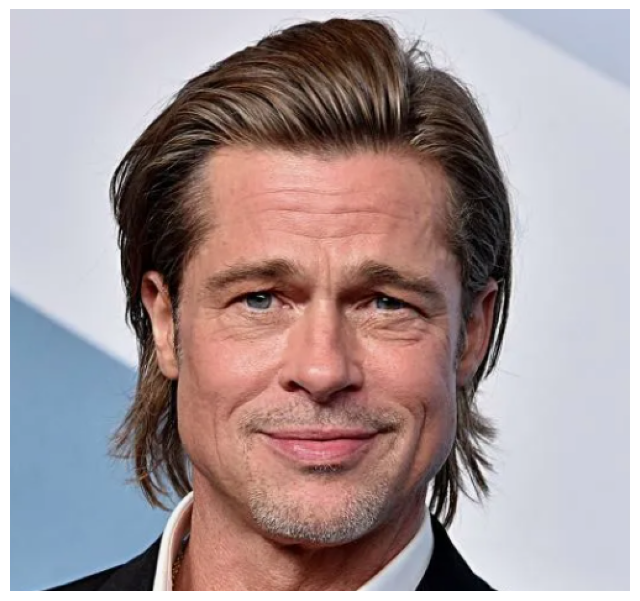

Predictions for this image:
5 o'clock shadow: Yes (Confidence: 0.92)
Arched Eyebrows: No (Confidence: 0.00)
Bags Under Eyes: Yes (Confidence: 0.78)
Bald: No (Confidence: 0.00)
Bangs: No (Confidence: 0.00)
Big Lips: No (Confidence: 0.01)
Black Hair: No (Confidence: 0.01)
Blond Hair: No (Confidence: 0.00)
Blurry: No (Confidence: 0.00)
Brown Hair: Yes (Confidence: 0.87)
Eyeglasses: No (Confidence: 0.00)
Goatee: Yes (Confidence: 1.00)
Gray Hair: No (Confidence: 0.00)
Heavy Makeup: No (Confidence: 0.00)
High Cheekbones: Yes (Confidence: 0.99)
Male: Yes (Confidence: 1.00)
Mouth Slightly Open: No (Confidence: 0.02)
Narrow Eyes: No (Confidence: 0.28)
No Beard: No (Confidence: 0.00)
Oval Face: No (Confidence: 0.04)
Pale Skin: No (Confidence: 0.00)
Pointy Nose: Yes (Confidence: 0.74)
Receding Hairline: No (Confidence: 0.17)
Rosy Cheeks: No (Confidence: 0.00)
Sideburns: No (Confidence: 0.24)
Smiling: Yes (Confidence: 1.00)
Straight Hair: Yes (Confidence: 0.96)
Wavy Hair: No (Confidence: 0.01)
Wea

In [49]:
from PIL import Image
image_path = '/kaggle/input/famous-person-cropped/Brad_Pitt.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

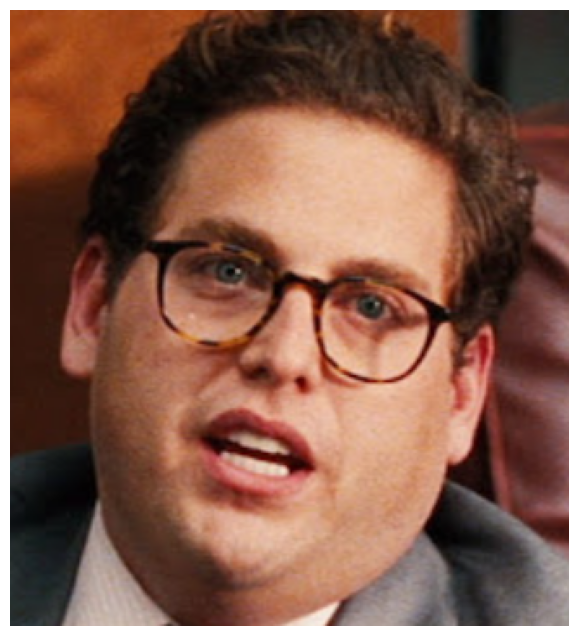

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.01)
Arched Eyebrows: No (Confidence: 0.00)
Attractive: No (Confidence: 0.01)
Bags Under Eyes: No (Confidence: 0.02)
Bald: No (Confidence: 0.00)
Bangs: No (Confidence: 0.00)
Big Nose: Yes (Confidence: 0.73)
Black Hair: No (Confidence: 0.01)
Blond Hair: No (Confidence: 0.00)
Blurry: No (Confidence: 0.09)
Bushy Eyebrows: No (Confidence: 0.01)
Chubby: Yes (Confidence: 0.96)
Double Chin: No (Confidence: 0.06)
Eyeglasses: Yes (Confidence: 1.00)
Goatee: No (Confidence: 0.03)
Gray Hair: No (Confidence: 0.00)
Heavy Makeup: No (Confidence: 0.00)
High Cheekbones: No (Confidence: 0.05)
Male: Yes (Confidence: 1.00)
Mouth Slightly Open: Yes (Confidence: 1.00)
Narrow Eyes: No (Confidence: 0.11)
Oval Face: No (Confidence: 0.09)
Pale Skin: No (Confidence: 0.00)
Pointy Nose: No (Confidence: 0.22)
Receding Hairline: No (Confidence: 0.13)
Rosy Cheeks: No (Confidence: 0.00)
Sideburns: No (Confidence: 0.01)
Smiling: No (Confidence: 0.01)
Wavy H

In [50]:
image_path = '/kaggle/input/famous-person-cropped/Hill.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

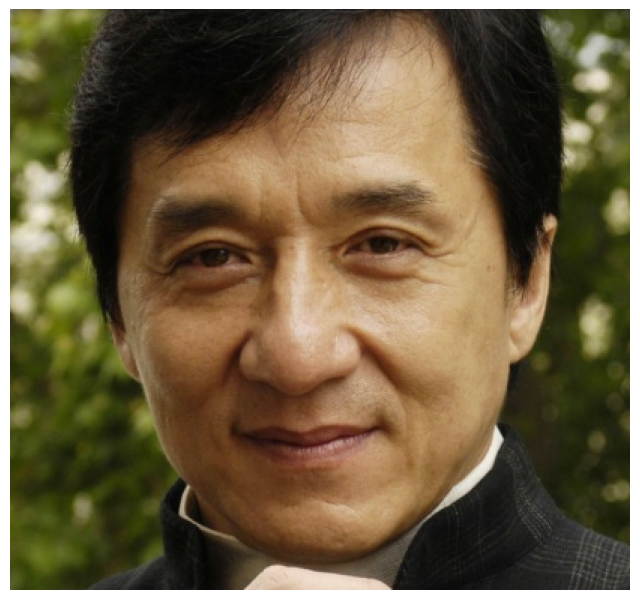

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.00)
Arched Eyebrows: No (Confidence: 0.00)
Attractive: No (Confidence: 0.00)
Bald: No (Confidence: 0.25)
Bangs: No (Confidence: 0.10)
Big Lips: No (Confidence: 0.04)
Big Nose: Yes (Confidence: 0.96)
Black Hair: No (Confidence: 0.18)
Blond Hair: No (Confidence: 0.02)
Blurry: No (Confidence: 0.01)
Brown Hair: No (Confidence: 0.00)
Bushy Eyebrows: No (Confidence: 0.26)
Chubby: Yes (Confidence: 0.99)
Eyeglasses: No (Confidence: 0.06)
Goatee: No (Confidence: 0.00)
Gray Hair: No (Confidence: 0.25)
Heavy Makeup: No (Confidence: 0.00)
Male: Yes (Confidence: 1.00)
Mouth Slightly Open: Yes (Confidence: 0.99)
Mustache: No (Confidence: 0.24)
Narrow Eyes: Yes (Confidence: 0.73)
Oval Face: No (Confidence: 0.06)
Pale Skin: No (Confidence: 0.00)
Pointy Nose: No (Confidence: 0.10)
Receding Hairline: No (Confidence: 0.07)
Rosy Cheeks: No (Confidence: 0.00)
Sideburns: No (Confidence: 0.00)
Smiling: Yes (Confidence: 0.85)
Straight Hair: Yes (

In [51]:
image_path = '/kaggle/input/famous-person-cropped/Jackie_Chan.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

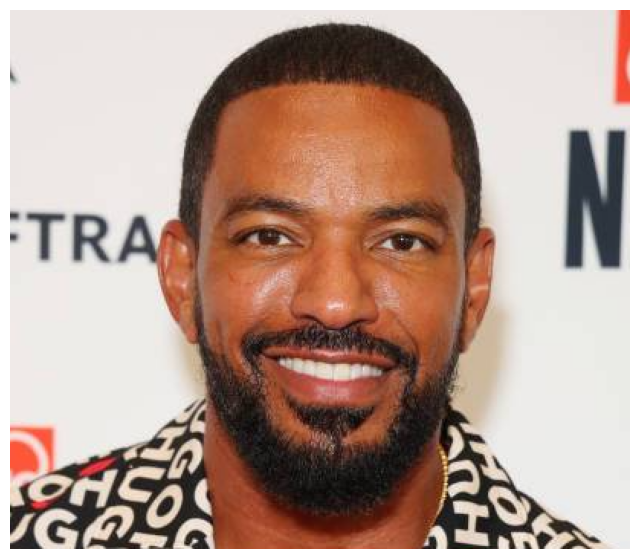

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.00)
Arched Eyebrows: No (Confidence: 0.00)
Attractive: No (Confidence: 0.00)
Bags Under Eyes: No (Confidence: 0.22)
Bangs: No (Confidence: 0.00)
Big Nose: Yes (Confidence: 0.96)
Black Hair: No (Confidence: 0.30)
Blond Hair: No (Confidence: 0.02)
Blurry: No (Confidence: 0.00)
Bushy Eyebrows: No (Confidence: 0.11)
Double Chin: No (Confidence: 0.20)
Goatee: Yes (Confidence: 1.00)
Gray Hair: No (Confidence: 0.00)
Heavy Makeup: No (Confidence: 0.00)
High Cheekbones: No (Confidence: 0.02)
Male: Yes (Confidence: 1.00)
Mouth Slightly Open: No (Confidence: 0.21)
Mustache: Yes (Confidence: 0.83)
No Beard: No (Confidence: 0.00)
Oval Face: No (Confidence: 0.05)
Pale Skin: No (Confidence: 0.00)
Pointy Nose: No (Confidence: 0.02)
Receding Hairline: Yes (Confidence: 0.99)
Rosy Cheeks: No (Confidence: 0.00)
Sideburns: Yes (Confidence: 0.99)
Smiling: No (Confidence: 0.03)
Straight Hair: No (Confidence: 0.00)
Wavy Hair: No (Confidence: 0.00

In [52]:
image_path = '/kaggle/input/famous-person-cropped/Laz_Alonso.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

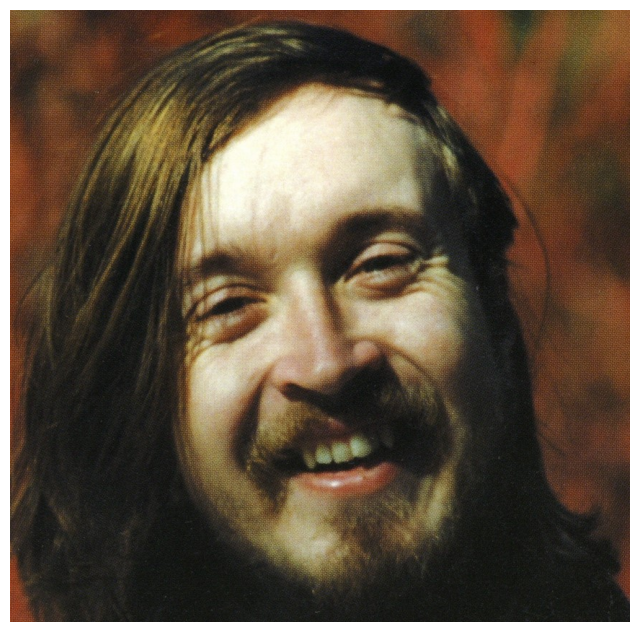

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.05)
Arched Eyebrows: No (Confidence: 0.09)
Attractive: No (Confidence: 0.01)
Bags Under Eyes: No (Confidence: 0.24)
Bald: No (Confidence: 0.00)
Bangs: No (Confidence: 0.00)
Black Hair: Yes (Confidence: 0.78)
Blond Hair: No (Confidence: 0.00)
Blurry: No (Confidence: 0.04)
Brown Hair: No (Confidence: 0.04)
Chubby: Yes (Confidence: 0.88)
Double Chin: Yes (Confidence: 0.83)
Eyeglasses: No (Confidence: 0.08)
Goatee: No (Confidence: 0.19)
Gray Hair: No (Confidence: 0.00)
Heavy Makeup: No (Confidence: 0.03)
High Cheekbones: No (Confidence: 0.00)
Male: Yes (Confidence: 0.90)
Mouth Slightly Open: Yes (Confidence: 1.00)
Mustache: Yes (Confidence: 0.89)
Narrow Eyes: Yes (Confidence: 0.85)
No Beard: No (Confidence: 0.00)
Oval Face: No (Confidence: 0.13)
Pale Skin: No (Confidence: 0.03)
Pointy Nose: No (Confidence: 0.04)
Receding Hairline: No (Confidence: 0.01)
Rosy Cheeks: No (Confidence: 0.00)
Sideburns: Yes (Confidence: 0.96)
Smilin

In [53]:
image_path = '/kaggle/input/famous-person-cropped/Letov.jpg'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

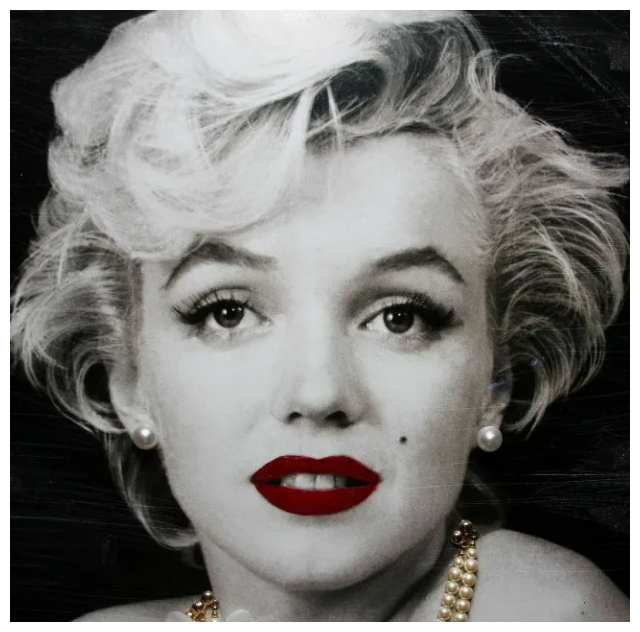

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.00)
Arched Eyebrows: Yes (Confidence: 0.94)
Attractive: Yes (Confidence: 0.98)
Bags Under Eyes: No (Confidence: 0.01)
Bald: No (Confidence: 0.00)
Bangs: No (Confidence: 0.00)
Big Lips: No (Confidence: 0.02)
Big Nose: No (Confidence: 0.18)
Black Hair: No (Confidence: 0.00)
Blurry: No (Confidence: 0.00)
Brown Hair: No (Confidence: 0.00)
Bushy Eyebrows: Yes (Confidence: 0.88)
Chubby: No (Confidence: 0.01)
Double Chin: No (Confidence: 0.00)
Eyeglasses: No (Confidence: 0.00)
Goatee: No (Confidence: 0.10)
Gray Hair: No (Confidence: 0.00)
Heavy Makeup: Yes (Confidence: 0.79)
High Cheekbones: No (Confidence: 0.02)
Male: No (Confidence: 0.00)
Mouth Slightly Open: No (Confidence: 0.03)
Mustache: No (Confidence: 0.02)
Narrow Eyes: No (Confidence: 0.00)
No Beard: Yes (Confidence: 0.99)
Pale Skin: Yes (Confidence: 1.00)
Pointy Nose: No (Confidence: 0.06)
Rosy Cheeks: No (Confidence: 0.00)
Sideburns: No (Confidence: 0.00)
Smiling: No (C

In [54]:
image_path = '/kaggle/input/famous-person-cropped/Marlyn_Monroe.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

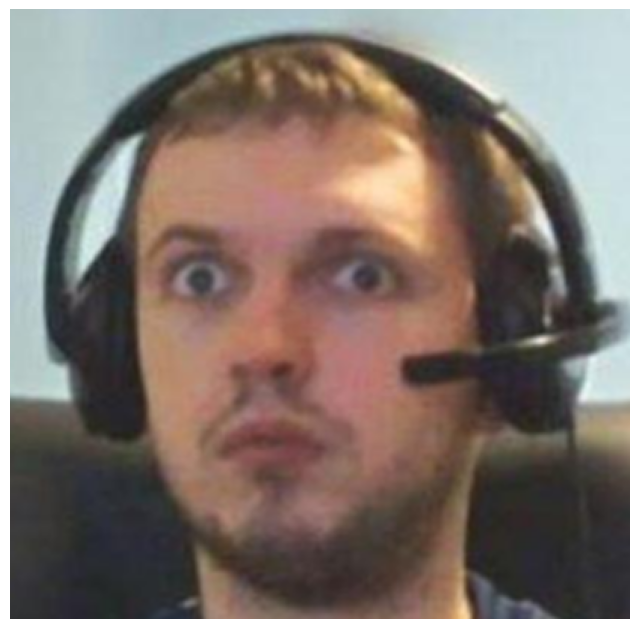

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.01)
Arched Eyebrows: No (Confidence: 0.00)
Attractive: No (Confidence: 0.00)
Bags Under Eyes: No (Confidence: 0.00)
Bald: No (Confidence: 0.00)
Bangs: No (Confidence: 0.00)
Big Lips: No (Confidence: 0.25)
Big Nose: No (Confidence: 0.05)
Black Hair: No (Confidence: 0.01)
Blurry: Yes (Confidence: 0.90)
Bushy Eyebrows: No (Confidence: 0.00)
Double Chin: No (Confidence: 0.06)
Goatee: Yes (Confidence: 1.00)
Gray Hair: No (Confidence: 0.04)
Heavy Makeup: No (Confidence: 0.00)
High Cheekbones: No (Confidence: 0.02)
Male: Yes (Confidence: 1.00)
Mouth Slightly Open: No (Confidence: 0.06)
Mustache: Yes (Confidence: 0.71)
No Beard: No (Confidence: 0.01)
Pale Skin: No (Confidence: 0.00)
Pointy Nose: No (Confidence: 0.07)
Receding Hairline: No (Confidence: 0.04)
Rosy Cheeks: No (Confidence: 0.00)
Smiling: No (Confidence: 0.08)
Wavy Hair: No (Confidence: 0.29)
Wearing Earrings: No (Confidence: 0.00)
Wearing Hat: No (Confidence: 0.26)
We

In [55]:
image_path = '/kaggle/input/famous-person-cropped/Papich.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

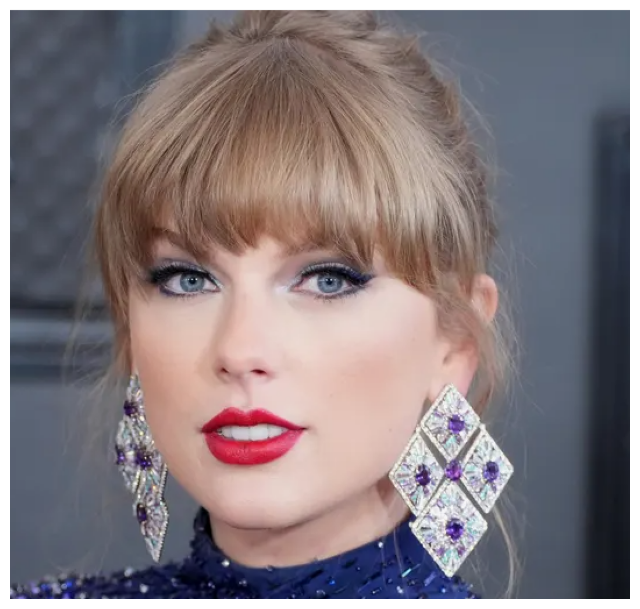

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.00)
Arched Eyebrows: No (Confidence: 0.04)
Attractive: No (Confidence: 0.28)
Bags Under Eyes: No (Confidence: 0.00)
Bald: No (Confidence: 0.00)
Bangs: Yes (Confidence: 1.00)
Big Nose: No (Confidence: 0.01)
Black Hair: No (Confidence: 0.00)
Blurry: No (Confidence: 0.00)
Bushy Eyebrows: No (Confidence: 0.01)
Chubby: No (Confidence: 0.00)
Double Chin: No (Confidence: 0.00)
Eyeglasses: No (Confidence: 0.01)
Goatee: No (Confidence: 0.00)
Gray Hair: No (Confidence: 0.00)
Heavy Makeup: Yes (Confidence: 0.91)
High Cheekbones: No (Confidence: 0.02)
Male: No (Confidence: 0.00)
Mouth Slightly Open: Yes (Confidence: 0.99)
Mustache: No (Confidence: 0.00)
No Beard: Yes (Confidence: 1.00)
Pale Skin: Yes (Confidence: 0.71)
Pointy Nose: Yes (Confidence: 0.72)
Receding Hairline: No (Confidence: 0.00)
Rosy Cheeks: No (Confidence: 0.11)
Sideburns: No (Confidence: 0.00)
Smiling: No (Confidence: 0.02)
Wavy Hair: No (Confidence: 0.21)
Wearing Ea

In [56]:
image_path = '/kaggle/input/famous-person-cropped/Taylor_Swift.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)

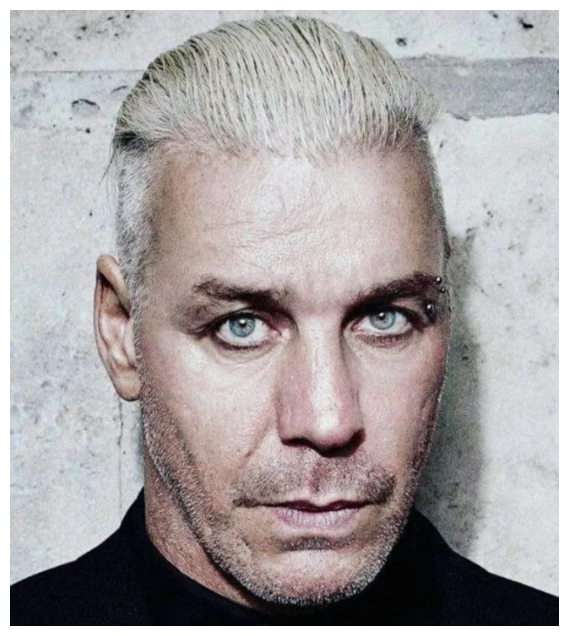

Predictions for this image:
5 o'clock shadow: No (Confidence: 0.04)
Arched Eyebrows: No (Confidence: 0.02)
Attractive: No (Confidence: 0.00)
Bags Under Eyes: Yes (Confidence: 0.74)
Bald: No (Confidence: 0.09)
Bangs: No (Confidence: 0.00)
Big Lips: No (Confidence: 0.17)
Big Nose: Yes (Confidence: 0.76)
Black Hair: No (Confidence: 0.00)
Blond Hair: Yes (Confidence: 0.82)
Blurry: No (Confidence: 0.00)
Brown Hair: No (Confidence: 0.00)
Bushy Eyebrows: Yes (Confidence: 0.91)
Chubby: No (Confidence: 0.04)
Double Chin: No (Confidence: 0.01)
Eyeglasses: No (Confidence: 0.01)
Goatee: No (Confidence: 0.03)
Gray Hair: Yes (Confidence: 0.95)
Heavy Makeup: No (Confidence: 0.02)
High Cheekbones: No (Confidence: 0.00)
Male: Yes (Confidence: 1.00)
Mouth Slightly Open: No (Confidence: 0.02)
Mustache: No (Confidence: 0.00)
Narrow Eyes: No (Confidence: 0.00)
No Beard: No (Confidence: 0.16)
Oval Face: No (Confidence: 0.05)
Pale Skin: Yes (Confidence: 1.00)
Pointy Nose: No (Confidence: 0.24)
Receding Hairl

In [57]:
image_path = '/kaggle/input/famous-person-cropped/Till_Lindemann.png'
image_tensor = preprocess_image(image_path)
predictions = predict_ensemble(image_tensor, device)
display_results(image_path, predictions)